## NYC Airbnb Price Prediction





In [2]:
import numpy as np 
import pandas as pd

from feature_engine.encoding import RareLabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, PowerTransformer, MinMaxScaler
)

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    KFold, RandomizedSearchCV, train_test_split
)

from sklearn.metrics import (
    mean_squared_log_error, r2_score
)

pd.set_option('display.precision', 2)

In [3]:
df = pd.read_csv("../Data/airbnb_imputed.csv")

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,34194.0,1.91e+07,1.10e+07,2539.00,9.51e+06,1.98e+07,2.92e+07,3.65e+07
host_id,34194.0,6.78e+07,7.88e+07,2438.00,7.86e+06,3.09e+07,1.07e+08,2.74e+08
latitude,34194.0,4.07e+01,5.46e-02,40.51,4.07e+01,4.07e+01,4.08e+01,4.09e+01
longitude,34194.0,-7.40e+01,4.61e-02,-74.24,-7.40e+01,-7.40e+01,-7.39e+01,-7.37e+01
price,34194.0,1.52e+02,2.35e+02,10.00,6.90e+01,1.05e+02,1.75e+02,1.00e+04
minimum_nights,34194.0,7.06e+00,2.07e+01,1.00,1.00e+00,3.00e+00,5.00e+00,1.25e+03
number_of_reviews,34194.0,2.32e+01,4.43e+01,0.00,1.00e+00,5.00e+00,2.30e+01,6.29e+02
reviews_per_month,34194.0,1.16e+00,1.59e+00,0.01,1.30e-01,5.10e-01,1.59e+00,5.85e+01
calculated_host_listings_count,34194.0,7.18e+00,3.30e+01,1.00,1.00e+00,1.00e+00,2.00e+00,3.27e+02
availability_365,34194.0,1.14e+02,1.32e+02,0.00,0.00e+00,4.60e+01,2.30e+02,3.65e+02


In [5]:
df.describe(include='object').T

,count,unique,top,freq
name,34194,33681,Hillside Hotel,15
host_name,34194,9148,Michael,309
neighbourhood_group,34194,5,Manhattan,15134
neighbourhood,34194,217,Williamsburg,2718
room_type,34194,3,Entire home/apt,17800
last_review,34194,1675,2019-06-23,1212


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34194 entries, 0 to 34193
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34194 non-null  int64  
 1   name                            34194 non-null  object 
 2   host_id                         34194 non-null  int64  
 3   host_name                       34194 non-null  object 
 4   neighbourhood_group             34194 non-null  object 
 5   neighbourhood                   34194 non-null  object 
 6   latitude                        34194 non-null  float64
 7   longitude                       34194 non-null  float64
 8   room_type                       34194 non-null  object 
 9   price                           34194 non-null  int64  
 10  minimum_nights                  34194 non-null  int64  
 11  number_of_reviews               34194 non-null  int64  
 12  last_review                     

In [6]:
df.isna().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

<Axes: >

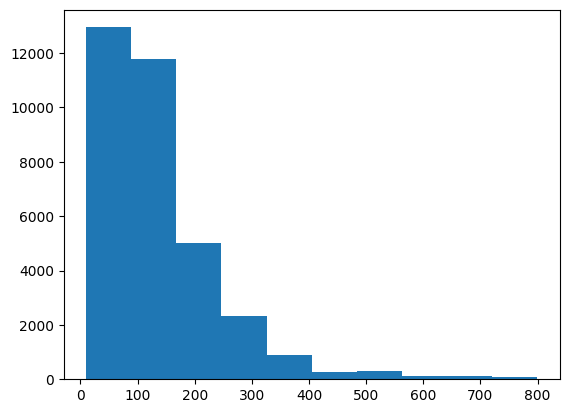

In [11]:
df = df.query("price > 0 & price < 800")
df['price'].hist(grid=False)
#df = df[df['price']>0]

In [12]:
df['last_review'] = pd.to_datetime(df['last_review'])
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,299531,Feel like you never leave your home,1220404,Tom,Brooklyn,East New York,40.67,-73.89,Entire home/apt,100,1,119,2019-06-30,1.39,2,289
1,2461439,Pristine Lower East Side Sanctuary,12586492,Sausan,Manhattan,Lower East Side,40.72,-73.99,Entire home/apt,133,14,177,2019-05-03,2.82,2,221
2,127387,"Luxe, Spacious 2BR 2BA Nr Trains",23276,Katharine,Brooklyn,Gowanus,40.67,-73.99,Entire home/apt,260,30,3,2014-08-04,0.03,1,316
3,629315,1BD brownstone apt in Fort Greene!,2397437,Lauren,Brooklyn,Fort Greene,40.69,-73.97,Entire home/apt,120,3,22,2015-10-28,0.27,1,189
4,4607923,LOVELY LARGE SUNNY ROOM Sunset Park,1113080,Audrey,Brooklyn,Sunset Park,40.65,-74.00,Private room,55,7,98,2019-05-22,1.75,3,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34189,32786275,Clean and Simple,82940021,Todd,Manhattan,Hell's Kitchen,40.76,-73.99,Entire home/apt,145,3,9,2019-07-01,3.55,1,6
34190,29829054,Best location in Williamsburg!,20827165,Melissa,Brooklyn,Williamsburg,40.72,-73.94,Entire home/apt,99,2,1,2018-11-19,0.13,2,0
34191,31857472,Hamilton Studio. 2Queen. priv bath. kitchenette,238750007,Hamilton,Manhattan,Harlem,40.82,-73.95,Entire home/apt,145,4,20,2019-07-02,3.66,3,310
34192,19197129,Best CoLiving next to Bushwick!,134293540,Valentin,Queens,Ridgewood,40.71,-73.90,Shared room,26,31,5,2018-05-04,0.22,4,365


In [13]:
df['price'] = df['price'].astype("float64")
df['name'] = df['name'].astype(object)
df.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

In [10]:
df['year'] = df.last_review.dt.year
df['month'] = df.last_review.dt.month

df[['year','month']].sample(5)

,year,month
15619,2016,7
30302,2019,2
20805,2019,7
6938,2018,7
22376,2017,12


In [31]:
X = df.drop(['price', 'host_id', 'host_name', 'id','longitude','latitude'],axis = 1)
y = np.log(df['price'])

num_cols = X.select_dtypes(include = np.number).columns.to_list()
cat_cols = X.select_dtypes(exclude = np.number).drop(['name','last_review'], axis=1).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.tail())

                                                    name neighbourhood_group  \
17012                            Great Williamsburg Spot            Brooklyn   
6310   Private room in East Harlem close to heart of NYC           Manhattan   
11385                 Cozy 1 BD apartment in Sunset park            Brooklyn   
864             ENJOY MANHATTAN\r\nNEAR TO YANKE STADIUM               Bronx   
15944                    Large & bright 900ft² 1br in WV           Manhattan   

      neighbourhood        room_type  minimum_nights  number_of_reviews  \
17012  Williamsburg     Private room               2                  0   
6310    East Harlem     Private room               2                  0   
11385   Sunset Park  Entire home/apt               1                 26   
864      Mott Haven     Private room               1                 29   
15944  West Village  Entire home/apt               4                  6   

      last_review  reviews_per_month  calculated_host_listings_count

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
pipe_cat = Pipeline(
    steps = [
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

pipe_num = Pipeline(
    steps = [
    ('scale', MinMaxScaler())
    ]
)

pipe_text = Pipeline(
    steps = [
        ('text_vec', CountVectorizer(analyzer='word',
                                     stop_words='english',
                                     max_features=30))
    ]
)

#pd.DataFrame(pipe_text.fit_transform(X_train['name']).toarray(), columns=pipe_text.get_feature_names_out())[:8]

In [33]:

preprocess = ColumnTransformer(
    transformers = [
    #('num', pipe_num, num_cols),
    ('text', pipe_text, 'name'),
    ('cat', pipe_cat, cat_cols)
    ],
    remainder='passthrough'
)

pd.DataFrame(preprocess.fit_transform(X_train), columns=preprocess.get_feature_names_out()).head(20)

,text__apartment,text__apt,text__beautiful,text__bed,text__bedroom,text__bright,text__brooklyn,text__central,text__cozy,text__east,...,cat__neighbourhood_Woodside,cat__room_type_Entire home/apt,cat__room_type_Private room,cat__room_type_Shared room,remainder__minimum_nights,remainder__number_of_reviews,remainder__last_review,remainder__reviews_per_month,remainder__calculated_host_listings_count,remainder__availability_365
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,2,2,2018-02-26,0.11,2,90
1,0,0,0,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,1,122,2019-06-17,5.42,1,193
2,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,2,7,2019-05-26,1.69,327,337
3,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,1.0,0.0,7,0,2019-06-23,0.34,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,1,23,2019-06-05,3.37,1,285
5,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,3,1,2017-11-06,0.05,1,0
6,0,1,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,3,40,2019-01-01,1.04,2,189
7,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,3,22,2019-05-28,1.62,1,278
8,1,0,0,0,0,0,1,0,1,0,...,0.0,1.0,0.0,0.0,1,14,2019-06-14,3.59,1,271
9,0,0,0,0,1,0,1,0,0,0,...,0.0,0.0,1.0,0.0,1,22,2019-07-06,10.31,3,347


In [34]:
from feature_engine.datetime import DatetimeFeatures
model = Pipeline(steps = [
    ('date_features', DatetimeFeatures(features_to_extract=['year','month','quarter','day_of_week','weekend'], variables=['last_review'])),
    ('rare', RareLabelEncoder(tol=0.03, variables=['neighbourhood'])),
    ('preprocessor', preprocess),
    ('lgbm', LGBMRegressor())
])


In [35]:
model_fit = model.fit(X_train, y_train) 
model_fit.score(X_test, y_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 23711, number of used features: 59
[LightGBM] [Info] Start training from score 4.704162


0.6246039359392623

In [25]:
y_pred = model_fit.predict(X_test)
y_pred

array([4.48466006, 4.79991346, 3.3807924 , ..., 5.20799278, 4.75096473,
       4.51566235])

In [36]:
print(f"RMSLE for LGBM: {np.sqrt(mean_squared_log_error(y_test, y_pred))},\
\nR2 for LGBM: {r2_score(y_test, y_pred)}")

RMSLE for LGBM: 0.0701942935530983,
R2 for LGBM: 0.6246039359392623


In [27]:
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor, AdaBoostRegressor
)
from xgboost import XGBRegressor

models = [
    ('huber', HuberRegressor()),
    ('gb', GradientBoostingRegressor()),
    ('ada', AdaBoostRegressor()),
    ('xgb', XGBRegressor())
] 

for name, model in models:
    pipe = Pipeline(steps=[
        ('date_features', DatetimeFeatures(features_to_extract=['year','month','quarter','day_of_week','weekend'], variables=['last_review'])),
        ('rare', RareLabelEncoder(tol=0.03, variables=['neighbourhood'])),
        ('preprocessor', preprocess),
        (name, model)
    ])
    
    pipe.fit(X_train,y_train)
    preds = pipe.predict(X_test)
    print(f"""{name} R2: {r2_score(y_test, preds)}
          {name} RMSLE: {np.sqrt(mean_squared_log_error(y_test, preds))}""")
    

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


huber R2: 0.46612923095701175
          huber RMSLE: 0.08530211188381726
gb R2: 0.6021125541212128
          gb RMSLE: 0.07219894622642901
ada R2: 0.4436865584218058
          ada RMSLE: 0.0864200945599825
xgb R2: 0.6164807034268014
          xgb RMSLE: 0.07098634158758446


## Otimização dos parâmetros do modelo

In [37]:
lgbm_grid = {
    'lgbm__num_leaves': [7, 14, 21],
    'lgbm__learning_rate': [0.1, 0.03, 0.001],
    'lgbm__max_depth': [-1, 3, 5],
    'lgbm__n_estimators': [200, 500, 1000],
    'preprocessor__text__text_vec__max_features': [10,20,50,150]
}

model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'date_features', 'rare', 'preprocessor', 'lgbm', 'date_features__dayfirst', 'date_features__drop_original', 'date_features__features_to_extract', 'date_features__format', 'date_features__missing_values', 'date_features__utc', 'date_features__variables', 'date_features__yearfirst', 'rare__ignore_format', 'rare__max_n_categories', 'rare__missing_values', 'rare__n_categories', 'rare__replace_with', 'rare__tol', 'rare__variables', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__text', 'preprocessor__cat', 'preprocessor__text__memory', 'preprocessor__text__steps', 'preprocessor__text__verbose', 'preprocessor__text__text_vec', 'preprocessor__text__text_vec__analyzer', 'preprocessor__text__text_vec__binary', 'preprocessor__text__text_vec__decode_error', 'preprocessor__

In [38]:
lgbm_tune = RandomizedSearchCV(
    model, 
    param_distributions = lgbm_grid,
    cv = 5,
    scoring = 'neg_mean_squared_log_error',
    return_train_score = True,
    n_iter = 10,
    verbose = 1,
    random_state = 42
)

In [39]:
lgbm_tune.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 18968, number of used features: 39
[LightGBM] [Info] Start training from score 4.702090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 18969, number of used features: 39
[LightGBM] [Info] Start training from score 4.703432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003149 seconds.
You can set `force_row_wi

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('date_features',
                                              DatetimeFeatures(features_to_extract=['year',
                                                                                    'month',
                                                                                    'quarter',
                                                                                    'day_of_week',
                                                                                    'weekend'],
                                                               variables=['last_review'])),
                                             ('rare',
                                              RareLabelEncoder(tol=0.03,
                                                               variables=['neighbourhood'])),
                                             ('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('text',
                                                                               Pipeline(steps=[('text_...
                                                                                'neighbourhood',
                                                                                'room_type'])])),
                                             ('lgbm', LGBMRegressor())]),
                   param_distributions={'lgbm__learning_rate': [0.1, 0.03,
                                                                0.001],
                                        'lgbm__max_depth': [-1, 3, 5],
                                        'lgbm__n_estimators': [200, 500, 1000],
                                        'lgbm__num_leaves': [7, 14, 21],
                                        'preprocessor__text__text_vec__max_features': [10,
                                                                                       20,
                                                                                       50,
                                                                                       150]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_log_error', verbose=1)

In [40]:
from joblib import dump
best_lgbm = lgbm_tune.best_estimator_
dump(best_lgbm, '../models/best_lgbm.pkl')

['../models/best_lgbm.pkl']

In [41]:
lgbm_tune.best_score_

-0.004814814664190133

<Axes: >

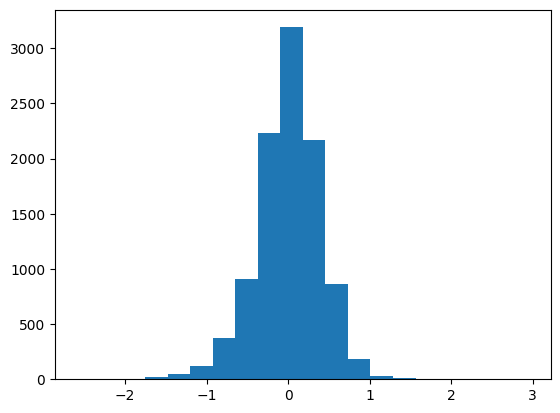

In [52]:
pd.Series((lgbm_tune.predict(X_test) - y_test)).hist(grid=False, bins=20)